In [1]:
import os
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk import FreqDist
import text2emotion as te
from LeXmo import LeXmo
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/meghanshubhatt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/meghanshubhatt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/meghanshubhatt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/meghanshubhatt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('data/data.csv')

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
bow = count_vect.fit_transform(df['SpeechNormalize'].values)
bow.shape

(74, 7744)

In [4]:
terms = count_vect.get_feature_names()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [5]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt


Text(0.5, 1.0, 'Elbow curve')

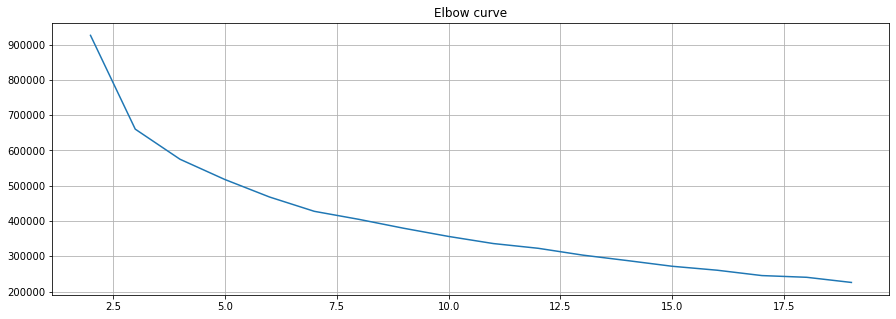

In [6]:
distorsions = []
for k in range(2, 20):
    model = KMeans(n_clusters = k)
    model.fit(bow)
    distorsions.append(model.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [7]:
model = KMeans(n_clusters = 4,init='k-means++',random_state=99)
model.fit(bow)

KMeans(n_clusters=4, random_state=99)

In [8]:
labels = model.labels_
cluster_center=model.cluster_centers_

In [9]:
labels

array([1, 0, 3, 3, 3, 3, 2, 2, 1, 1, 3, 1, 1, 2, 3, 3, 2, 0, 2, 0, 2, 0,
       0, 0, 0, 0, 3, 2, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       3, 3, 0, 3, 3, 0, 0, 1, 0, 3, 0, 0, 0, 2, 0, 0, 0, 2, 0, 3, 2, 2,
       0, 0, 3, 0, 2, 2, 2, 0], dtype=int32)

In [10]:
cluster_center

array([[2.44444444, 0.05555556, 0.        , ..., 0.08333333, 0.05555556,
        0.05555556],
       [6.83333333, 0.16666667, 0.        , ..., 2.16666667, 0.16666667,
        0.5       ],
       [5.64285714, 0.07142857, 0.07142857, ..., 0.28571429, 0.14285714,
        0.5       ],
       [4.44444444, 0.05555556, 0.        , ..., 0.11111111, 0.        ,
        0.        ]])

In [11]:
# which tells us that clusters are far away from each other
from sklearn import metrics
silhouette_score = metrics.silhouette_score(bow, labels, metric='euclidean')
silhouette_score

0.2216960543452112

In [12]:
# Giving Labels/assigning a cluster to each point/text 
df['Label'] = model.labels_ # the last column you can see the label numebers
df.head(10)

,Speech,Speech Word Frequency,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,NumWords,SpeechNormalize,Label
0,trump: wow. whoa. that some group people. thou...,<FreqDist with 922 samples and 2793 outcomes>,0.010292,0.024700,0.004460,0.009777,0.019383,0.020926,0.060206,0.010978,0.021269,0.039280,4950,trump wow whoa that some group people thousand...,1
1,good evening. thank you very much speak you t...,<FreqDist with 608 samples and 1166 outcomes>,0.019704,0.034483,0.008867,0.027094,0.028571,0.033990,0.049754,0.019212,0.024138,0.044335,1813,good evening thank you very much speak you tod...,0
2,"thank you for the opportunity speak you, and t...",<FreqDist with 948 samples and 1745 outcomes>,0.011639,0.028128,0.004203,0.020045,0.021985,0.038797,0.054963,0.010023,0.009053,0.040414,2820,thank you for the opportunity speak you and th...,3
3,thank you for joining today. this was going sp...,<FreqDist with 742 samples and 1539 outcomes>,0.027550,0.017126,0.011541,0.036485,0.010052,0.044676,0.039836,0.022338,0.008563,0.032018,2438,thank you for joining today this was going spe...,3
4,today like share thoughts about the stakes thi...,<FreqDist with 877 samples and 1751 outcomes>,0.018206,0.030122,0.008275,0.023171,0.016220,0.038067,0.047004,0.019199,0.011917,0.039722,2743,today like share thoughts about the stakes thi...,3
5,thank you like thank chairman jeff miller for ...,<FreqDist with 737 samples and 1305 outcomes>,0.016028,0.034283,0.009795,0.023152,0.020926,0.041852,0.071683,0.016474,0.014248,0.064559,2022,thank you like thank chairman jeff miller for ...,3
6,"thank you, everybody. great honor. great honor...",<FreqDist with 733 samples and 1805 outcomes>,0.011338,0.023783,0.004701,0.012998,0.016869,0.022677,0.057246,0.010232,0.014381,0.043971,3129,thank you everybody great honor great honor th...,2
7,"friends, delegates and fellow americans humbly...",<FreqDist with 1195 samples and 2486 outcomes>,0.015996,0.028660,0.006221,0.024661,0.023772,0.036881,0.057987,0.019551,0.009109,0.046656,4088,friends delegates and fellow americans humbly ...,2
8,donald trump been 235 days since crooked hilla...,<FreqDist with 1158 samples and 4371 outcomes>,0.012100,0.021119,0.010845,0.013014,0.013356,0.024543,0.054909,0.014269,0.023288,0.033219,7552,donald trump been days since crooked hillary c...,1
9,how good? how good? special. special special...,<FreqDist with 1233 samples and 3962 outcomes>,0.014858,0.028610,0.008104,0.019278,0.023207,0.030452,0.050958,0.016331,0.016085,0.037942,7081,how good how good special special special man ...,1


In [13]:
# How many points belong to each cluster -> using group by in pandas
df.groupby(['Label'])['SpeechNormalize'].count()

Label
0    36
1     6
2    14
3    18
Name: SpeechNormalize, dtype: int64

In [14]:
#to find the top 10 features of cluster centriod
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = count_vect.get_feature_names()
for i in range(4):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
        print()

Top terms per cluster:
Cluster 0: the
 and
 will
 our
 for
 are
 that
 you
 going
 this
Cluster 1: the
 and
 you
 that
 they
 have
 going
 but
 people
 our
Cluster 2: the
 and
 you
 that
 they
 our
 will
 have
 going
 for
Cluster 3: the
 and
 our
 will
 for
 that
 are
 this
 have
 clinton


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


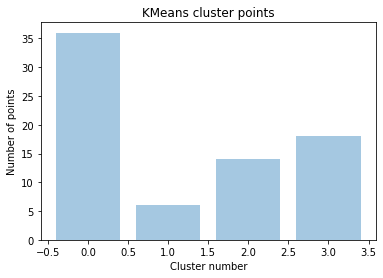

In [15]:
# visually how points or reviews are distributed across 10 clusters 
import matplotlib.pyplot as plt
plt.bar([x for x in range(4)], df.groupby(['Label'])['SpeechNormalize'].count(), alpha = 0.4)
plt.title('KMeans cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()

In [16]:
from wordcloud import WordCloud
def getClusterAnalysis(i):
    
    
# Create a WordCloud object
    wordcloud = WordCloud(width=800, height=500, max_font_size=110, background_color="white", max_words=3000, contour_width=3, contour_color='steelblue')

    all_words = ''.join([word for word in df[df['Label'] == i]['SpeechNormalize']]).replace('\n', '.')

    # Generate a word cloud
    wordcloud.generate(all_words)
    print('Total speechs ',df[df['Label'] == i]['SpeechNormalize'].shape[0])
    # Visualize the word cloud
    return wordcloud.to_image()

Total speechs  36


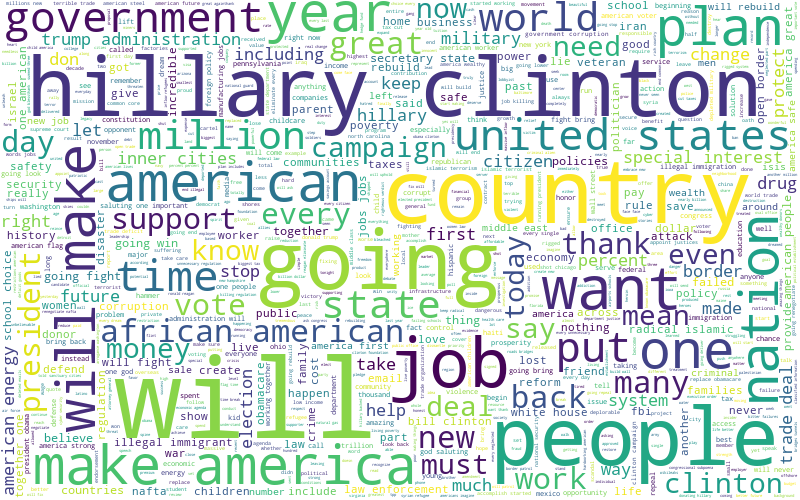

In [17]:
getClusterAnalysis(0)

Total speechs  6


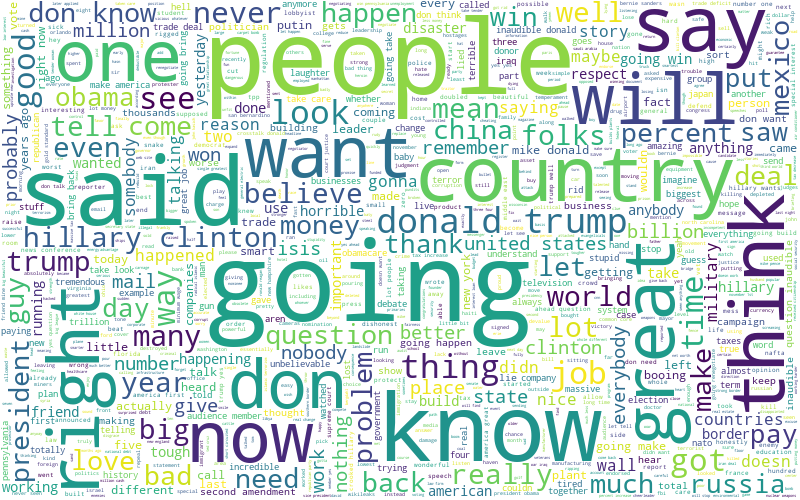

In [18]:
getClusterAnalysis(1)

Total speechs  14


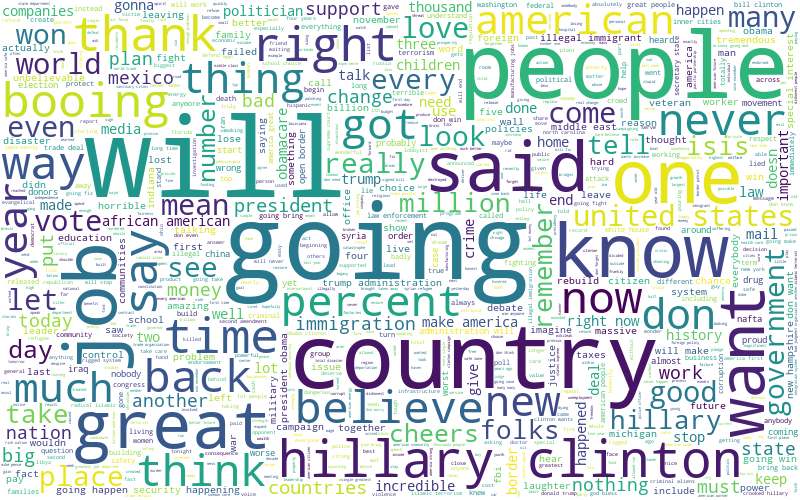

In [19]:
getClusterAnalysis(2)

Total speechs  18


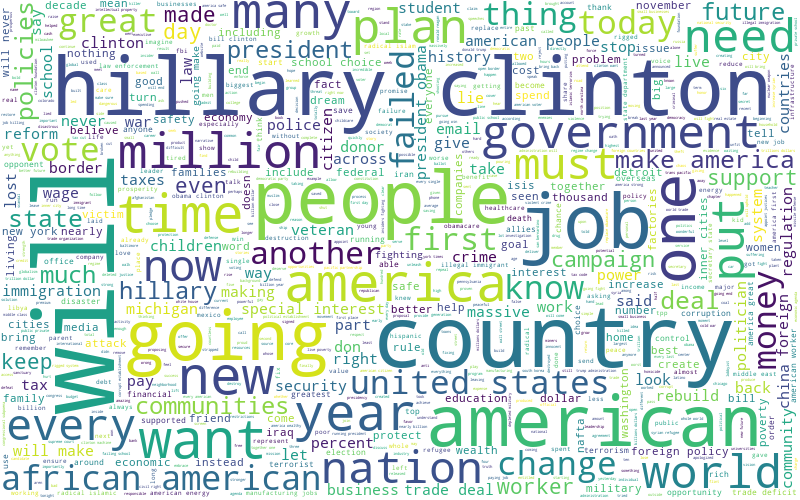

In [20]:
getClusterAnalysis(3)

In [22]:
df.to_csv('data/cluster.csv',index=False)